In [1]:
pip install biopython

  Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "pandas<2.0.0"

  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.0.14 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.collections import PathCollection
import geopandas as gpd
import pandas as pd
import numpy as np
import gzip
import pickle
import copy
import kDNA_annotation as ka
import statistics
import re

plt.show()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
#get deletion and editing seuqences
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict 
def read_insertions(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
def strain_minis(csv):
    df=pd.read_csv(csv,index_col='renamed') #set a new index
    mini_dict={strain:set(df.loc[strain][~(df.loc[strain].isna())].index) for strain in df.index}
    return(mini_dict)


def get_gRNA_info (txt,csv=False,matches=False):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{index}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for index,line in enumerate(handle)}
        mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
        for key in gRNA_dict:
            x1=int(gRNA_dict[key]['mRNA_start'])
            x2=int(gRNA_dict[key]['mRNA_end'])
            x3=int(gRNA_dict[key].get('anchor_len',6))
            x4=gRNA_dict.get('expression','expressed')
            mRNA_dict[gRNA_dict[key]['mRNA_name']].append((x1,x2,x3,x4))
        if matches != False:
            #matches='/home/jovyan/minicircle_annotation/Tbg1_cleaned_minicircles.log'
            match_dict={list(filter(None,l.strip('\n').split(' ')))[1]:list(filter(None,l.strip('\n').split(' ')))[0] for l in open(matches)} #translate mini naming system
            print(match_dict)
            for k in gRNA_dict:
                gRNA_dict[k]['mO_name']=match_dict[gRNA_dict[k]['mO_name']]
    #assign minicircle/gRNAs to each strain (using old copy number analysis)
    return(gRNA_dict,mRNA_dict)

def find_gap2(dictionary,insertions,key): #mrna_dict
    gaps,edits=[],copy.deepcopy(insertions)
    for i in sorted(dictionary[key]):
        for site in range(i[0],i[1]-6):
            edits[site]+=1
    x=[i for i,j in enumerate(edits) if j ==0]
    return(x)

def draw_grna(coor,adj=0,y=0.5,color='blue'):
    xstart=int(coor[0])-adj
    xend=int(coor[1])-adj
    anchor_len=int(coor[2])
    hl=(xend-xstart)/10
    plt.arrow(xend,y,-anchor_len,0,head_width=0, head_length=0, width=0.2,fc='red', ec='None',alpha=0.5) #draw anchor
    plt.arrow(xend-anchor_len,y,(xstart-xend+anchor_len+hl),0,head_width=0.2, head_length=hl, width=0.2,fc=color, ec=color,alpha=0.5)
    #plt.vlines(xstart,1,y,colors='k',linestyles='dashed',alpha=0.4)

def plot_alignment(dictionary,key,y=1,adj=0,arrowcolor='skyblue',up=False,fold=3):
    yheight,count,y0=len(dictionary[key])/fold,0,y
    for coor in sorted(dictionary[key],key=lambda x:x[1]):
        draw_grna(coor,adj,y=y,color=arrowcolor)
        count+=1
        if up == False:
            y-=0.2
        else:
            y+=0.2
        if count >= yheight:
            ymin=y
            y=y0
            count=0
    return(ymin)
    
def gRNA_depth(mRNA,mrna_dict,key):
    total=np.array([0]*len(mRNA))
    for pair in mrna_dict[key]:
        total+=np.array([0]*(pair[0]-1)+[1]*(pair[1]-pair[0]-8+1)+[0]*(len(mRNA)-pair[1]+8)) #-8 instead -pair[2]
    return(total)

def plot_mRNA_gRNA(mRNAs,strain_mrna,key,Outdir,lw=4, #mRNA-dicts+strain--> strain_mrna
                   y=0.1,adj=0,arrowcolor='black',up=False,fold=3,figw=20,figh=10,output='mRNA_coverage'): #with dots
    #
    insertions=[0 if b=='u' else 1 for b in mRNAs[key]['seq']] #read_editing_sites(small_u)
    deletion=[0 if b!='-' else 1 for b in mRNAs[key]['deletions']] #read_deletion_sites(dels)
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))   
    axs.axis('off')
    start=-0.3
    ymin=0
    #label numbers for mRNA length
    for i in range(0,len(insertions),50):
        axs.text(i,ymin,f"{i}",fontsize=10)
    ymin-=0.5
    #draw insertion sites: 0 for insertions
    x=[i for i,c in enumerate(insertions) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='purple',linewidth=5)
    ymin-=1
    #draw deletions
    x=[i for i,c in enumerate(deletion) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='red',linewidth=5)
    ymin+=-1
    #find the last editing site
    last1,last2=0,0
    for i,b in enumerate(deletion):
        if b=='0':
            last1=i
    for i,b in enumerate(insertions):
        if b=='0':
            last2=i
    last=max(last1,last2)
    #plot gRNA alignment
    gaps,gap_dict=[],{}
    for strain in strain_mrna:
        ymin-=2
        mRNA_dict=strain_mrna[strain]
        yprevious=ymin
        y=ymin
        ymin=plot_alignment(mRNA_dict,key,y,adj,arrowcolor,up,fold)
        axs.hlines(ymin,0,len(insertions),colors='k',linestyles='dashed',alpha=0.4)
        axs.text(0,ymin,f"{strain} {key}",fontsize=25,horizontalalignment='right')
        y=ymin-0.5
        #plot gRNA coverage on mRNA
        #grna_depth=gRNA_depth(mRNA,mRNA_dict,key) 
        #axs.plot(range(len(mRNA)),grna_depth,label=f'gRNA coverage {strain}')
        x=find_gap2(mRNA_dict,insertions,key)
        if x !='[]':
            axs.plot(x,[yprevious+1]*len(x),'^',color='black')
            for i in x:
                axs.vlines(i,yprevious+1,ymin,colors='k',linestyles='dashed',alpha=0.4)
        #print(find_gap(mRNA_dict,key),ymin,yprevious)
    #plot borders of gRNA coverage gaps
    #gaps=find_gap(mRNA_dict,key)
    #if the last editing sites are covered:
    axs.tick_params(axis='y', labelsize= 15)
    #axs.set_facecolor("white")
    plt.savefig(f'{Outdir}/{output}.pdf', format="pdf", bbox_inches="tight")
    plt.show()
    return(insertions)
##rename minicircles in gRNA dict using clean_mini_log
def rename_minicircles(gRNA_dict,clean_mini_log):
    match_dict={list(filter(None,l.strip('\n').split(' ')))[0]:list(filter(None,l.strip('\n').split(' ')))[1] for l in open(clean_mini_log)}
    match_dict['Maxicircle']='Maxicircle'
    for g in gRNA_dict:
        m=match_dict[gRNA_dict[g]['mO_name']]
        gRNA_dict[g]['mO_name']=m
        gRNA_dict[g]['name']=gRNA_dict[g]['name'].replace(gRNA_dict[g]['mO_name'],m)
    return(gRNA_dict)

In [5]:
#get information for all strains including copy number of minicircles
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    try:
        metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    except:
        print('already removed')
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)

def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
def strain_mini(combined):
    strain_mini_sets={strain: [idx for idx in combined.loc[strain][~(combined.loc[strain].isna())].index if 'Tb_mO' in idx] for strain in combined.index}
    return(strain_mini_sets)

csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
meta=meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_2024-09-02.csv'
metadf2,combined=process_df(csv,meta2)
#minor corrections of the taxon
taxon_correct={'T.b. gambiense type I':'T.b. gambiense type I','T.b. gambiense type II':'T.b. gambiense type II',
                              'T.b. brucei':'T.b. brucei','T.b. rhodesiense':'T.b. rhodesiense',
                             'T.b.':'T. brucei','T. brucei':'T. brucei'}
taxa=[taxon_correct.get(t,'T. brucei') for t in combined['taxon']]
combined['taxon']=taxa
combined['minicircle_classes'] = combined.count(axis=1)-9
strain_mini_sets=strain_mini(combined)
combined['network_size']=[sum([combined.loc[strain,i] for i in strain_mini_sets[strain]]) for strain in combined.index]

already removed


In [6]:
#mRNA
gRNA_exp='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_mongo_gRNAs_2024-05-15.txt'
#
def set_prefix(prefix):
    fig_dir = f'{prefix}_Figures'
    tab_dir = f'{prefix}_Tables'
    config_file = f'config_{prefix}.yaml'
    return(fig_dir,tab_dir,config_file)
figure_dir,tables_dir,config_file=set_prefix('Tbg1_Mongo')
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]
#
grna_mongo,mrna_mongo=get_gRNA_info (gRNA_exp)
features_with_exp_file = f"{work_dir}/{config['features pickle file']}"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features_with_exp_file)
mRNAs['ND8_v3']=mRNAs['ND8_v1']
outdir='/home/jovyan/Minicircle_gRNA_families/TbgI_Mongo_gRNA_outputs'

file config_Tbg1_Mongo.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_Tbg1_Mongo/features.pickle.gz loaded


mean: 39.741379310344826 sd: 5.62


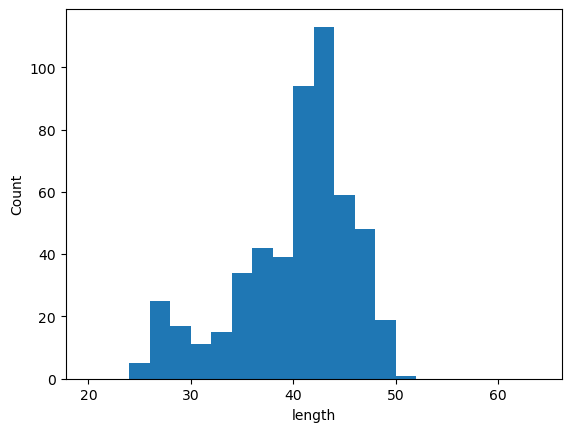

In [7]:
#
def plot_stats(key,grna_dict,s=20,e=65):
    x=[int(grna_dict[g][key]) for g in grna_dict]
    mean=sum(x)/len(x)
    sd=round(statistics.stdev(x),2)
    print(f"mean: {mean} sd: {sd}")
    fig,ax = plt.subplots(1,1)  #,figsize=(figw,figh)
    ax.hist(x,bins=range(s,e,2))
    ax.set_ylabel('Count')
    ax.set_xlabel(key)
    plt.show()
    
plot_stats('length',grna_mongo,s=20,e=65)

In [8]:
#for mrna in mRNAs.keys():
#    plot_mRNA_gRNA(mRNAs,{'Mongo':mrna_mongo},mrna,outdir,y=-3.3,fold=3,figw=30,figh=5,output=f'{mrna}_gRNA_coverage_1')

In [50]:
#coverage summary
def gRNA_coverage_mongo(mRNAs,strain,outdir,width=0.35, figw=30,figh=10):
    df = pd.DataFrame(columns=['all insertions','covered insertions','uncovered insertions','all deletions','covered deletions','uncovered deletions'], index=mRNAs.keys())
    for k in mRNAs:
        inserts=[0 if b=='t' or b=='u' else 1 for b in mRNAs[k]['edits']] #0 for editing sites
        dels=[0 if i=='-' else int(i) for i in mRNAs[k]['deletions']] #record the actual number of deleted U
        edited=mRNAs[k]['edited']
        inserted=[0 if i==0 and j ==0 else 1 for i,j in zip(inserts,edited)] #0 for uncovered editing sites, 1 for other
        deleted=[i if j==0 else 0 for i,j in zip(dels, edited)]
        #populate df
        if k =='COX2':
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)
            df.loc[k,'uncovered insertions']=0
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        #elif k =='MURF2':
        #    print('MURF2')
        #    df.loc[k,'all insertions']=inserts.count(0)
        #    df.loc[k,'covered insertions']=inserts.count(0)-1
         #   df.loc[k,'uncovered insertions']=1
         #   df.loc[k,'all deletions']=sum(dels)
         #   df.loc[k,'covered deletions']=sum(dels)
         #   df.loc[k,'uncovered deletions']=0
        elif k =='COX3_v2':
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)+1
            df.loc[k,'uncovered insertions']=inserted.count(0)-1
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        else:
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)
            df.loc[k,'uncovered insertions']=inserted.count(0)
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)-sum(deleted)
            df.loc[k,'uncovered deletions']=sum(deleted)
    if 'ND8_v3' not in df.index:
        df.loc['ND8_v3','all insertions']=260
        df.loc['ND8_v3','covered insertions']=260-df.loc['ND8_v1','uncovered insertions']
        df.loc['ND8_v3','uncovered insertions']=df.loc['ND8_v1','uncovered insertions']
        df.loc['ND8_v3','all deletions']=47
        df.loc['ND8_v3','covered deletions']=47-df.loc['ND8_v1','uncovered deletions']
        df.loc['ND8_v3','uncovered deletions']=df.loc['ND8_v1','uncovered deletions']
  #output df for a quick check
    df=df.sort_index()
    print(df)
    df.to_csv(f'{outdir}/{strain}_gRNA_coverage.csv', index=True)  
  #plot the statistics
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))  
    x=np.arange(0,len(df.index),1)*(width*1.2)
    axs.bar(x, (df['covered insertions']+df['covered deletions']), width, label='covered',
              color='cornflowerblue')
    axs.bar(x, (df['uncovered insertions']+df['uncovered deletions']), width, 
              bottom=(df['covered insertions']+df['covered deletions']),label='not covered',
              color='lightcoral')
  #styling
    axs.set_xticks(x)
    axs.set_xticklabels(list(df.index),) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Number of Editing sites',fontsize=20)
  #axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
  #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
  #plt.grid(True)
    plt.show()

        all insertions covered insertions uncovered insertions all deletions  \
A6_v1              443                434                    9            28   
A6_v2              444                444                    0            28   
COX2                 4                  4                    0             0   
COX3_v1            544                544                    0            42   
COX3_v2            544                544                    0            42   
CR3                142                142                    0            10   
CR4                328                328                    0            44   
CYB                 34                 34                    0             0   
MURF2               26                 24                    2             4   
ND3                211                211                    0            19   
ND7                550                543                    7            86   
ND8_v1             259                23

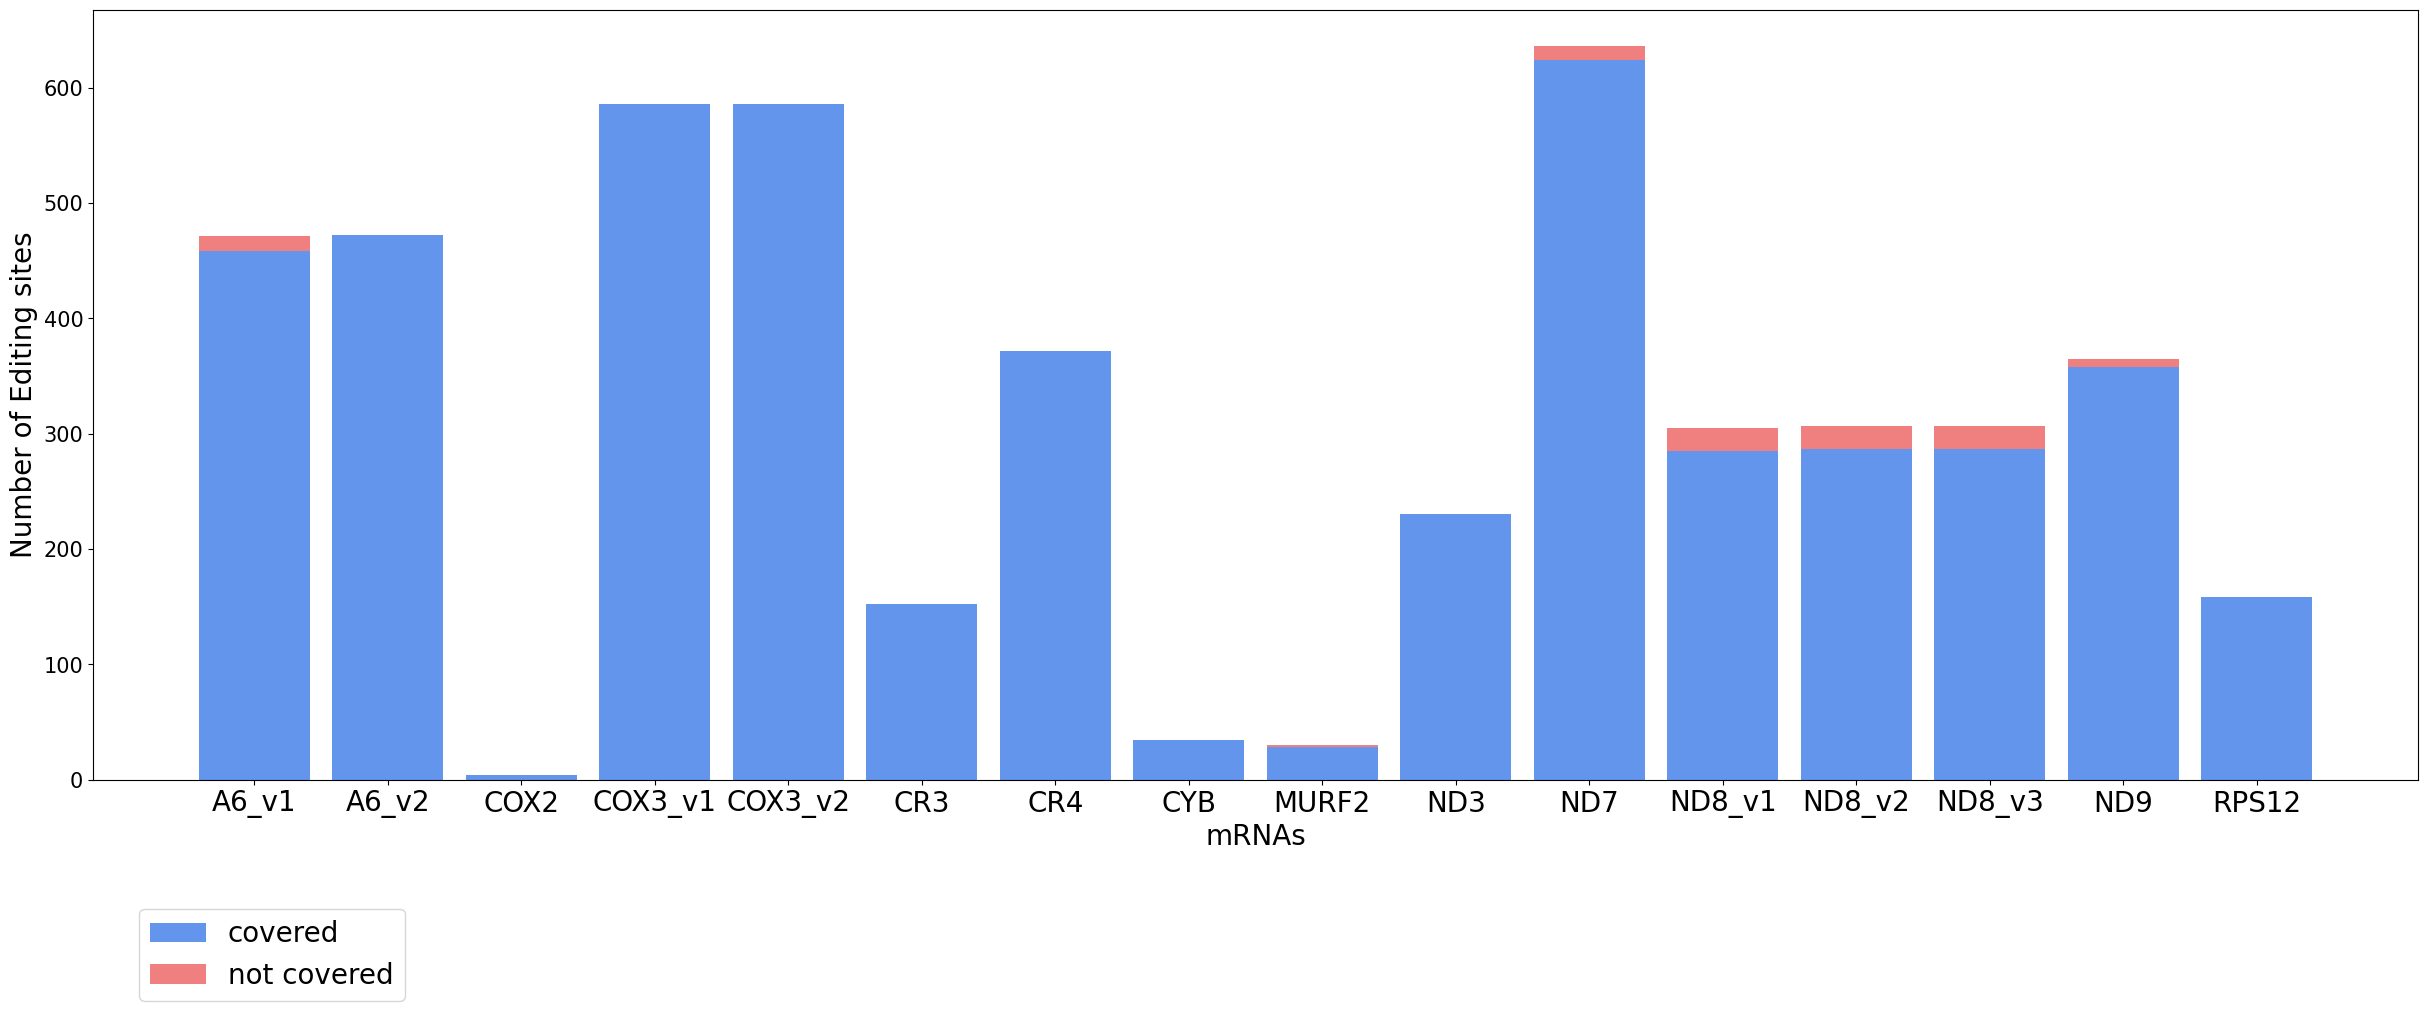

In [51]:
gRNA_coverage_mongo(mRNAs,'Mongo', outdir,width=0.35, figw=30,figh=10)

In [11]:
#coverage summary
def gRNA_coverage2(mRNAs,strain,outdir,width=0.35, figw=30,figh=10):
    df = pd.DataFrame(columns=['all insertions','covered insertions','uncovered insertions','all deletions','covered deletions','uncovered deletions'], index=mRNAs.keys())
    for k in mRNAs:
        inserts=[0 if b== 'u' else 1 for b in mRNAs[k]['seq']] #0 for editing sites
        dels=[0 if i=='-' else int(i) for i in mRNAs[k]['deletions']] #record the actual number of deleted U
        edited=mRNAs[k]['edited']
        inserted=[0 if i==0 and j ==0 else 1 for i,j in zip(inserts,edited)] #0 for uncovered editing sites, 1 for other
        deleted=[i if j==0 else 0 for i,j in zip(dels, edited)]
        #populate df
        if k =='COX2':
            print(k)
            print(mRNAs[k]['edits'])
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)
            df.loc[k,'uncovered insertions']=0
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        #elif k =='MURF2':
        #    print('MURF2')
        #    df.loc[k,'all insertions']=inserts.count(0)
        #    df.loc[k,'covered insertions']=inserts.count(0)-1
         #   df.loc[k,'uncovered insertions']=1
         #   df.loc[k,'all deletions']=sum(dels)
         #   df.loc[k,'covered deletions']=sum(dels)
         #   df.loc[k,'uncovered deletions']=0
        else:
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)
            df.loc[k,'uncovered insertions']=inserted.count(0)
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)-sum(deleted)
            df.loc[k,'uncovered deletions']=sum(deleted)
  #output df for a quick check
    df=df.sort_index()
    print(df)
    df.to_csv(f'{outdir}/{strain}_gRNA_coverage.csv', index=True)  
  #plot the statistics
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))  
    x=np.arange(0,len(df.index),1)*(width*1.2)
    axs.bar(x, (df['covered insertions']+df['covered deletions']), width, label='covered',
              color='cornflowerblue')
    axs.bar(x, (df['uncovered insertions']+df['uncovered deletions']), width, 
              bottom=(df['covered insertions']+df['covered deletions']),label='not covered',
              color='lightcoral')
  #styling
    axs.set_xticks(x)
    axs.set_xticklabels(list(df.index),) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Number of Editing sites',fontsize=20)
  #axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
  #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
  #plt.grid(True)
    plt.show()

In [12]:
#type OVI
#figure_dir,tables_dir,config_file=set_prefix('OVI_strains')
#config = ka.load_config(config_file)
#work_dir, annotation_dir = ka.get_directories(config)[1:3]
features = f"/home/jovyan/gRNA_analysis/Work_files_OVI_strains/features.pickle.gz"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features)

file /home/jovyan/gRNA_analysis/Work_files_OVI_strains/features.pickle.gz loaded


COX2
TAATAATAACAAATGAGTTTTATATTAACTTTTTGAATGATATTTTTAATGGATTCAATAATTGTATTAATATCTTTTTCAATATTTTTATCTGTATGAATATGTACATTGATTATAGCAACAGTATTAACTGTAACAAAAATGAATAATATATATTGTACATGAGATTTTATATCATCAAAATTTATAGATACATATTGGTTTGTACTCGGAATGATGTTTATATTGTGTTTATTGTTAAGGTTGTGTTTGTTGTTGTATTTTAGTTGTATAAATTTTGTGAGTTTTGATTTGTGTAAAGTAATAGGTTTTCAGTGATATTGGGTATATTTTTTATTTGGAGAAACTACAATATTTAGTAATTTAATATTAGAAAGTGATTATTTAATAGGAGATTTAAGAATATTACAGTGTAACCATGTATTGACATTGTTAAGTTTGGTTATTTATAAATTATGAGTATCTGCAGTAGATGTAATACATTCATTCACAATATCAAGTTTAGGTATAAAAGTAGAttGtAtACCTGGTAGGTGTAATGAAATAATTTTGTTTGCCACAAATAATGCAACTCTTTACGGTCAATGTAGTGAATTGTGTGGTGTATTACACGGTTTTATGCCTATTGTGATAAATTTTATATAGGAAGGTATATAATCTATTAATGAAAGGGGATTT
       all insertions covered insertions uncovered insertions all deletions  \
A6_v1             441                441                    0            28   
A6_v2             442                431                   11            28   
COX2                4                  4                    0             0   


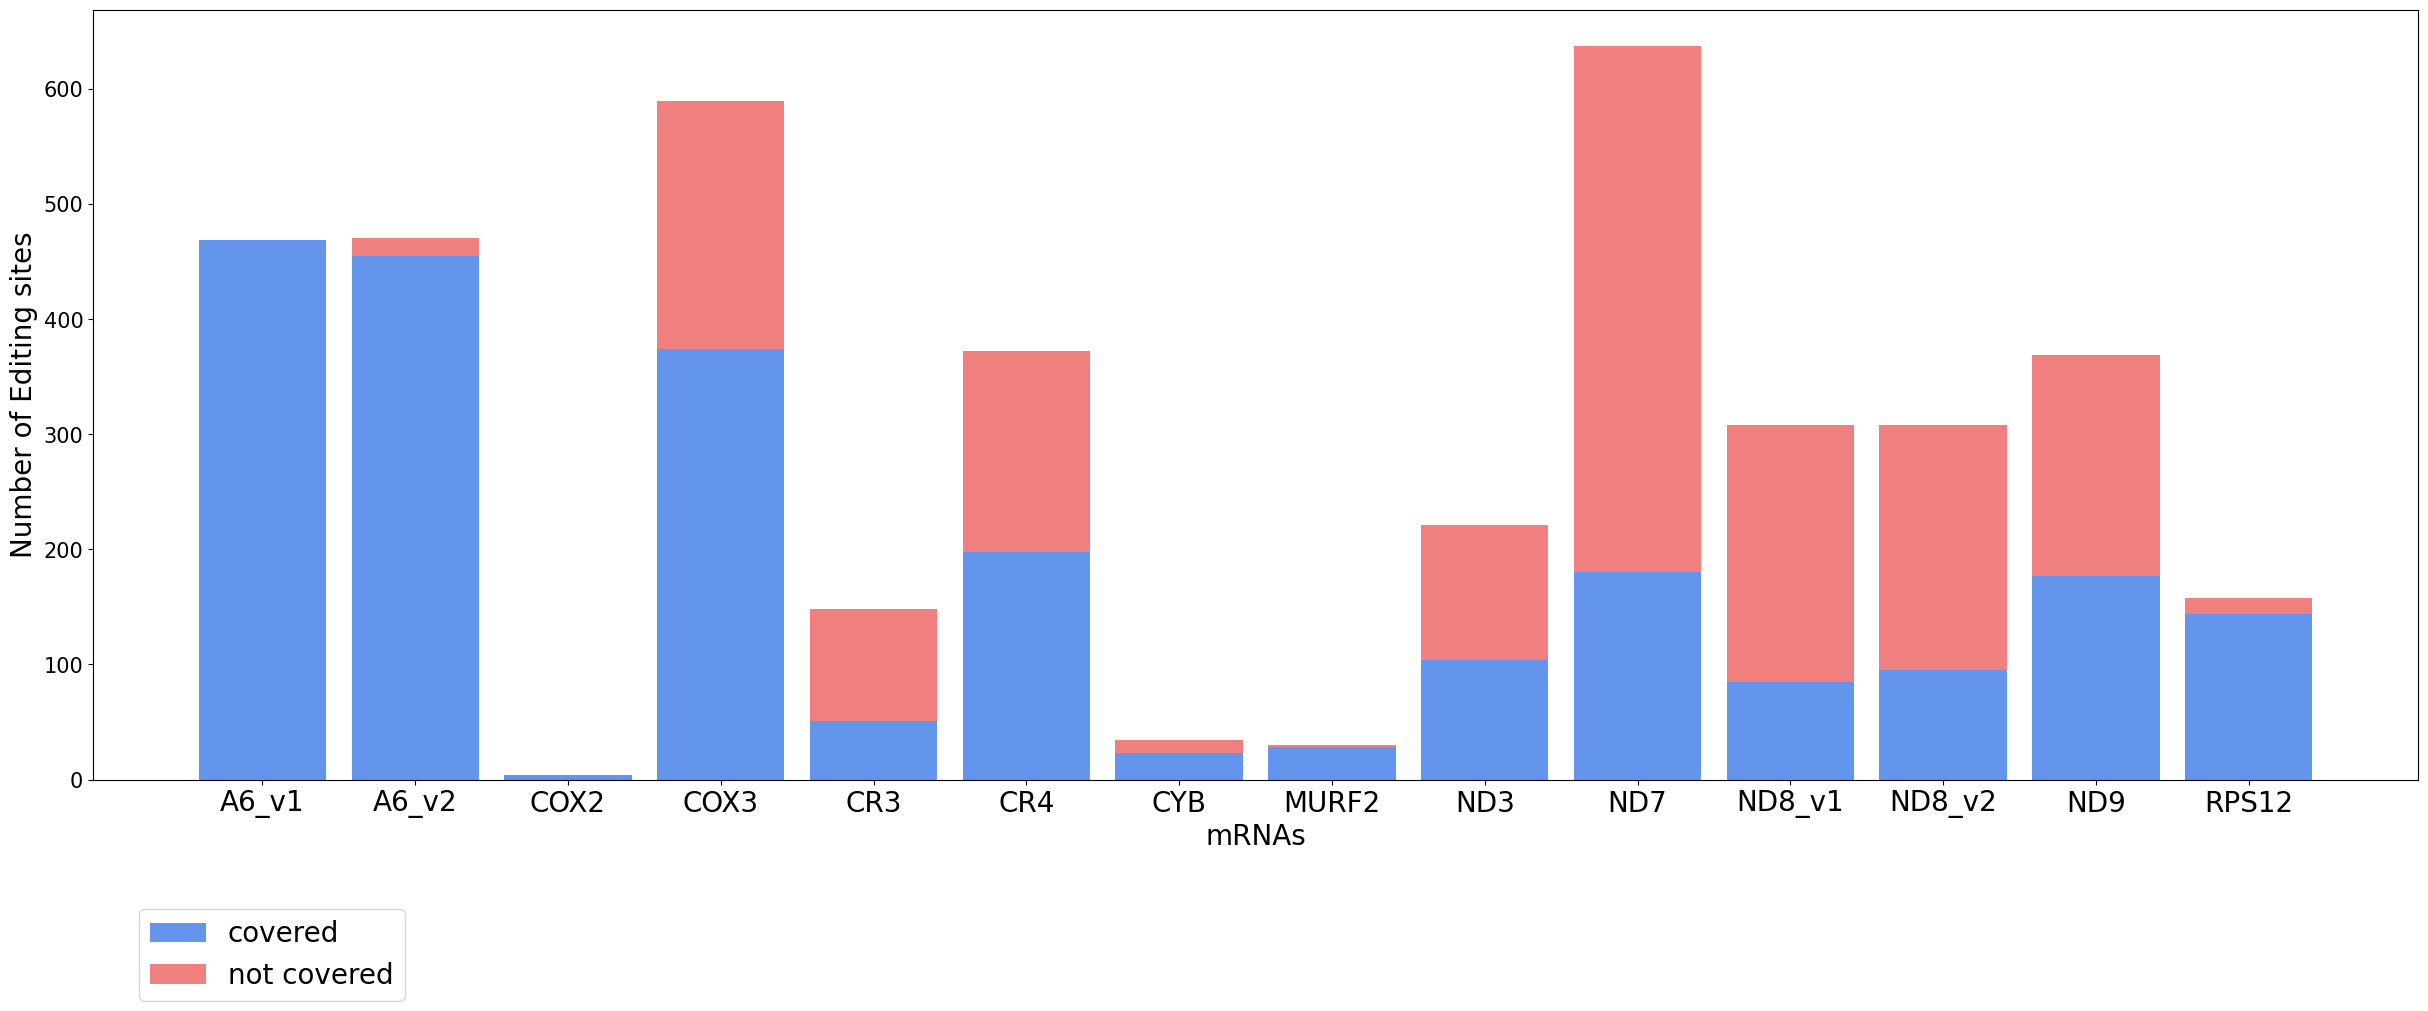

In [13]:
gRNA_coverage2(mRNAs,'OVI', outdir,width=0.35, figw=30,figh=10)

In [14]:
#edit all mincircles
#mRNA
tbg1all='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_gRNAs_2024-05-17.txt'
#

figure_dir,tables_dir,config_file=set_prefix('Tbg1')
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]
#
tbg1grna,tbg1mrna=get_gRNA_info (tbg1all)
features_with_exp_file = f"{work_dir}/{config['features pickle file']}"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features_with_exp_file)
outdir='/home/jovyan/Minicircle_gRNA_families/TbgI_Mongo_gRNA_outputs'

file config_Tbg1.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_Tbg1/features.pickle.gz loaded


        all insertions covered insertions uncovered insertions all deletions  \
A6_v1              443                434                    9            28   
A6_v2              444                444                    0            28   
COX2                 4                  4                    0             0   
COX3_v1            544                544                    0            42   
COX3_v2            544                544                    0            42   
CR3                142                142                    0            10   
CR4                328                328                    0            44   
CYB                 34                 34                    0             0   
MURF2               26                 24                    2             4   
ND3                211                211                    0            19   
ND7                550                543                    7            86   
ND8_v1             259                23

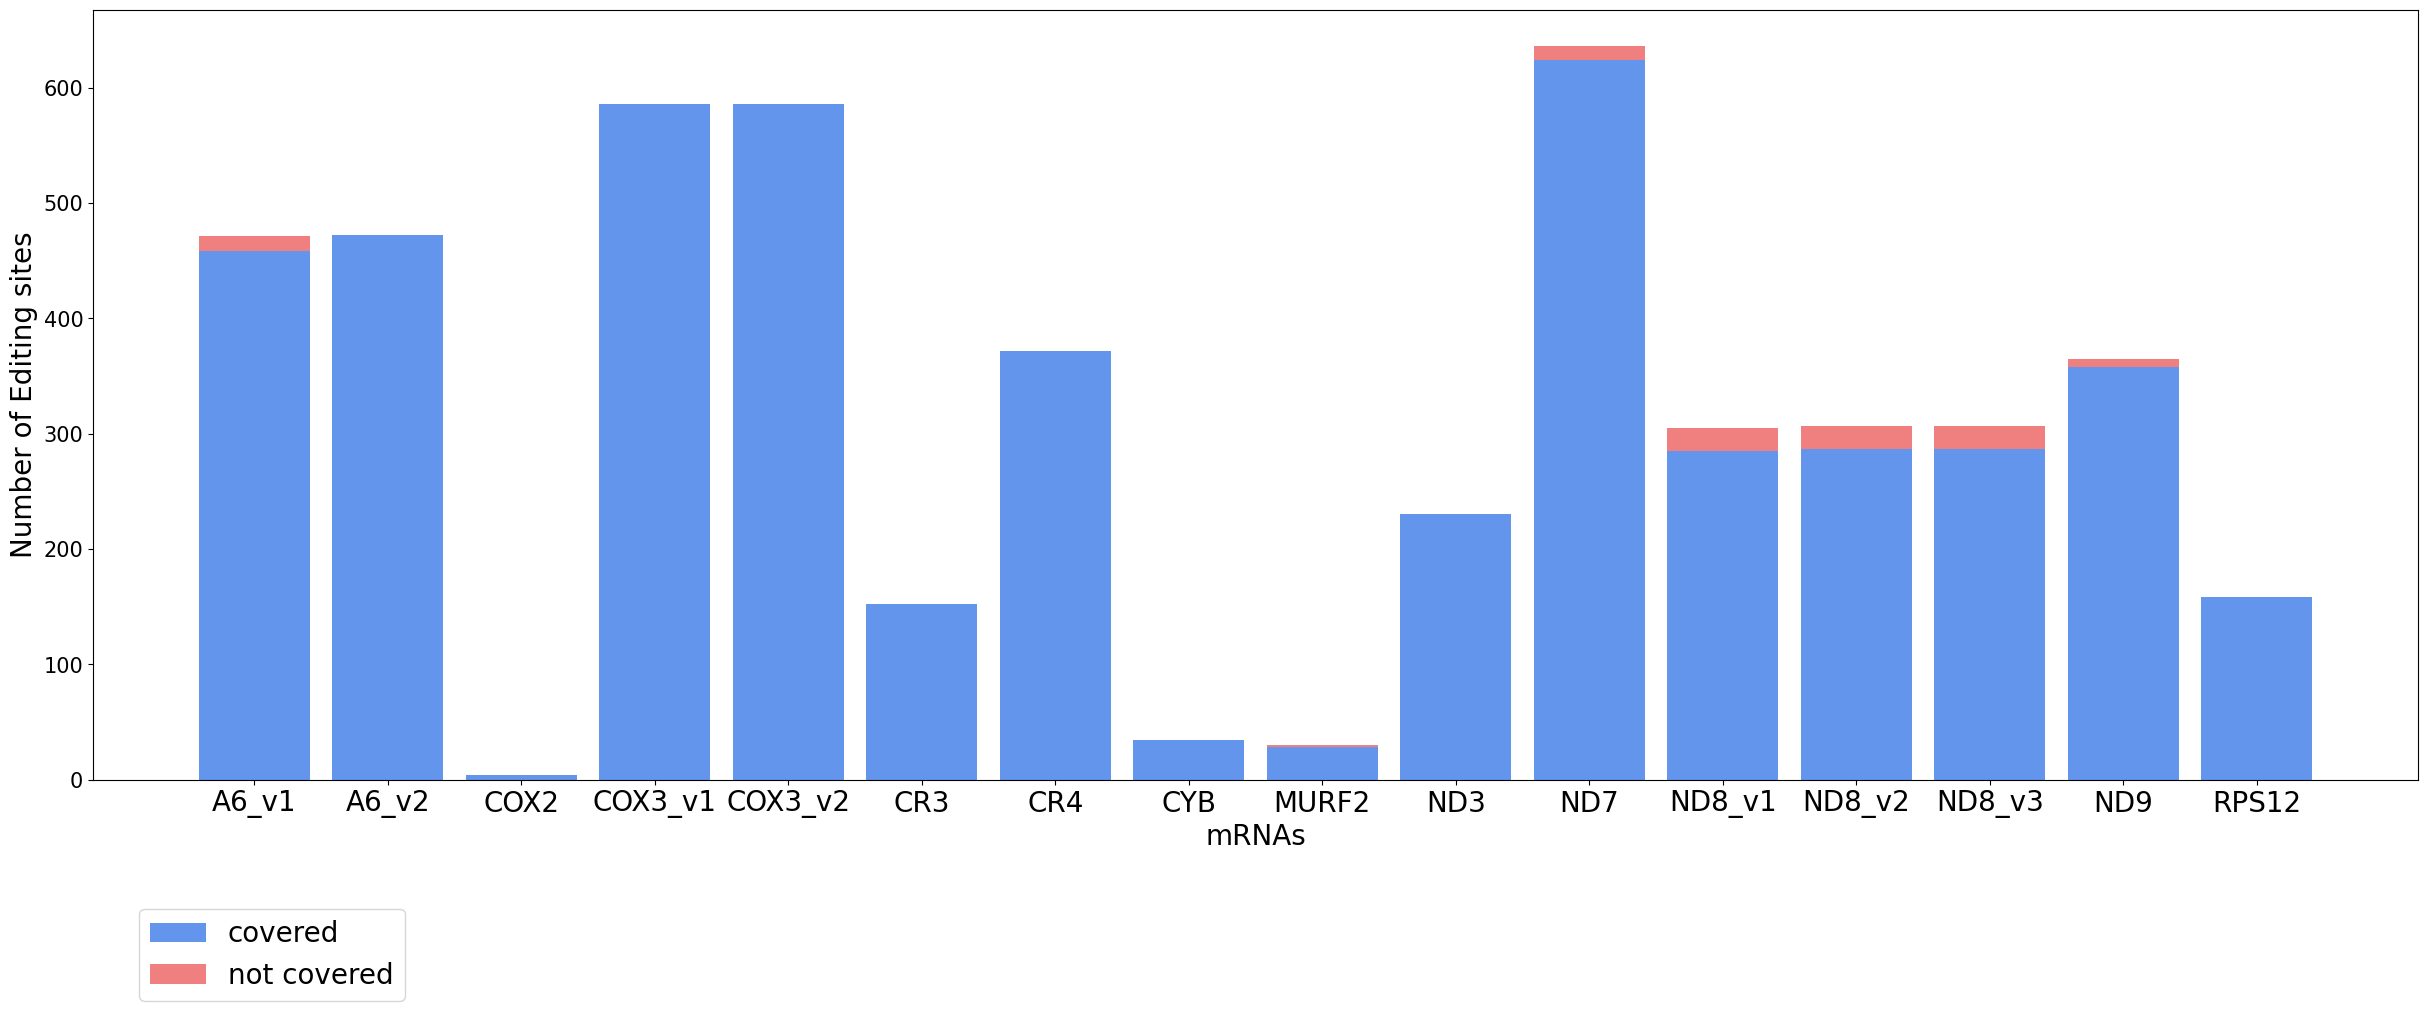

In [52]:
gRNA_coverage_mongo(mRNAs,'TbgI', outdir,width=0.35, figw=30,figh=10)

In [29]:
#gRNA coverage of non tbgI Tb (other Tb)
#extract minicircles present in other Tb
def pickle_load2(file,prefix,tmp):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    print('\ncopy and run the following line to store variables:\n')
    variables=[f"{prefix}_{n}" for n in out[-1]]
    store=[f"{tmp}[{i}]" for i in range(len(out))]
    line=f"{','.join(variables)}={','.join(store)}"
    print(line)
    return out
def extract_other(df,taxon):
    #others
    other=df[df['taxon']==taxon]
    other=other.dropna(axis=1, how='all') #drop all na columns
    print(len(other), len([k for k in other.columns if k.startswith('Tb_mO_')]))
    inother=[k for k in other.columns if k.startswith('Tb_mO_')]
    numberofmini=other.count(axis=1)
    #print(numberofmini)
    return(inother)
#extract gRNAs present in other Tb
def extract_gRNA_present(gRNA_dict,minilist):
    grnas={k:v for k,v in gRNA_dict.items() if v['mO_name'] in minilist}
    print(f"{len(grnas)}/{len(gRNA_dict)} gRNAs were present in {len(minilist)} minicircles")
    return(grnas)
def make_mRNA_files(insertions,deletions):
    mRNAs={k:{'edits':str(insertions[k].seq),'deletions':str(deletions[k].seq),'edited':np.zeros(len(insertions[k])),'unique gRNA':0} for k in insertions}
    return(mRNAs)
#get coverage
def make_gRNA_coverage(grnas,mrnas,anchor=6):
    for g,v in grnas.items():
        coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
        mrna=v['mRNA_name']
        mrnas[mrna]['unique gRNA']+=1
        for i in range(coverage[0],min(coverage[1],len(mrnas[mrna]['edited']))):
            mrnas[mrna]['edited'][i]+=1 #set insertions to 0
    return (mrnas)
#excutions
#coverage summary
def gRNA_coverage(mRNAs,strain,outdir,width=0.35, figw=30,figh=10):
    df = pd.DataFrame(columns=['unique gRNAs','all insertions','covered insertions','uncovered insertions','all deletions','covered deletions','uncovered deletions'], index=mRNAs.keys())
    for k in mRNAs:
        inserts=[0 if b=='u' else 1 for b in mRNAs[k]['edits']] #0 for editing sites
        dels=[0 if i=='-' else int(i) for i in mRNAs[k]['deletions']] #record the actual number of deleted U
        edited=mRNAs[k]['edited']
        if k=='A6_v2': #set all sites outside the alternative editing sites as edited (>760)
            sites=[766,781]
            inserted=[0 if p[0]==0 and p[1] ==0 and i >= sites[0] and i<= sites[1] else 1 for i,p in enumerate(zip(inserts,edited))] #0 for uncovered editing sites, 1 for other
            #deleted=[i if j==0 else 0 for i,j in zip(dels, edited)]
            deleted=[i if p[1] ==0 and i >= sites[0] and i<= sites[1] else 0 for i,p in enumerate(zip(dels,edited))]
        elif k=='ND8_v2':
            sites=[378,508,515] #only alternative editing sites
            iinserted=[0 if p[0]==0 and p[1] ==0 and (i >= sites[1] and i<= sites[2] or i == sites[0]) else 1 for i,p in enumerate(zip(inserts,edited))]
            deleted=[i if p[1] ==0 and (i >= sites[1] and i<= sites[2] or i == sites[0]) else 0 for i,p in enumerate(zip(dels,edited))]
        else:
            inserted=[0 if i==0 and j ==0 else 1 for i,j in zip(inserts,edited)] #0 for uncovered editing sites, 1 for other
            deleted=[i if j==0 else 0 for i,j in zip(dels, edited)]
        #print(k,','.join([str(int(i)) for i in edited]))

        #populate df
        df.loc[k,'unique gRNAs']=mRNAs[k]['unique gRNA']
        if k =='COX2':
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)
            df.loc[k,'uncovered insertions']=0
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        elif k =='MURF2':
            print('MURF2')
            df.loc[k,'all insertions']=inserts.count(0)
            #df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)
            #df.loc[k,'uncovered insertions']=inserted.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-1
            df.loc[k,'uncovered insertions']=1
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        else:
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)
            df.loc[k,'uncovered insertions']=inserted.count(0)
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)-sum(deleted)
            df.loc[k,'uncovered deletions']=sum(deleted)
  #output df for a quick check
    df=df.sort_index()
    #print(df)
    df.to_csv(f'{outdir}/{strain}_gRNA_coverage.csv', index=True)  
  #plot the statistics
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))  
    x=np.arange(0,len(df.index),1)*(width*1.2)
    axs.bar(x, (df['covered insertions']+df['covered deletions']), width, label='covered',
              color='cornflowerblue')
    axs.bar(x, (df['uncovered insertions']+df['uncovered deletions']), width, 
              bottom=(df['covered insertions']+df['covered deletions']),label='not covered',
              color='lightcoral')
  #styling
    axs.set_xticks(x)
    axs.set_xticklabels(list(df.index),) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Number of Editing sites',fontsize=20)
  #axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
  #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
  #plt.grid(True)
    plt.show() 
    return(df)


In [17]:
for i,p in enumerate(zip([1,2,3,4],[5,6,7,8])):
    print(i,p)

0 (1, 5)
1 (2, 6)
2 (3, 7)
3 (4, 8)


In [18]:
#Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle'
pickled='/home/jovyan/Minicircle_gRNA_families/In_files/merged_gRNAs.pickle'
small_u='/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_edited_mRNA_small_u.fasta'
deletion='/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_deletions_mRNA.txt'
#
other_tb='/home/jovyan/Minicircle_gRNA_families/Work_files/other_Tb/other_Tb_updated_4_dicts.pickle'
tmp8=pickle_load2(other_tb,'tb','tmp8')
gRNA_dict,tb_gRNA_families,tb_mini_dict,tb_renamed_mini_family,tb_save=tmp8[0],tmp8[1],tmp8[2],tmp8[3],tmp8[4]
#gRNA_dict=pickle_load(pickled)
insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
deletions=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))

file /home/jovyan/Minicircle_gRNA_families/Work_files/other_Tb/other_Tb_updated_4_dicts.pickle loaded

copy and run the following line to store variables:

tb_gRNA_dict,tb_gRNA_families,tb_mini_dict,tb_renamed_mini_family,tb_save=tmp8[0],tmp8[1],tmp8[2],tmp8[3],tmp8[4]


14 1850
4496/13401 gRNAs were present in 1850 minicircles
4496
MURF2


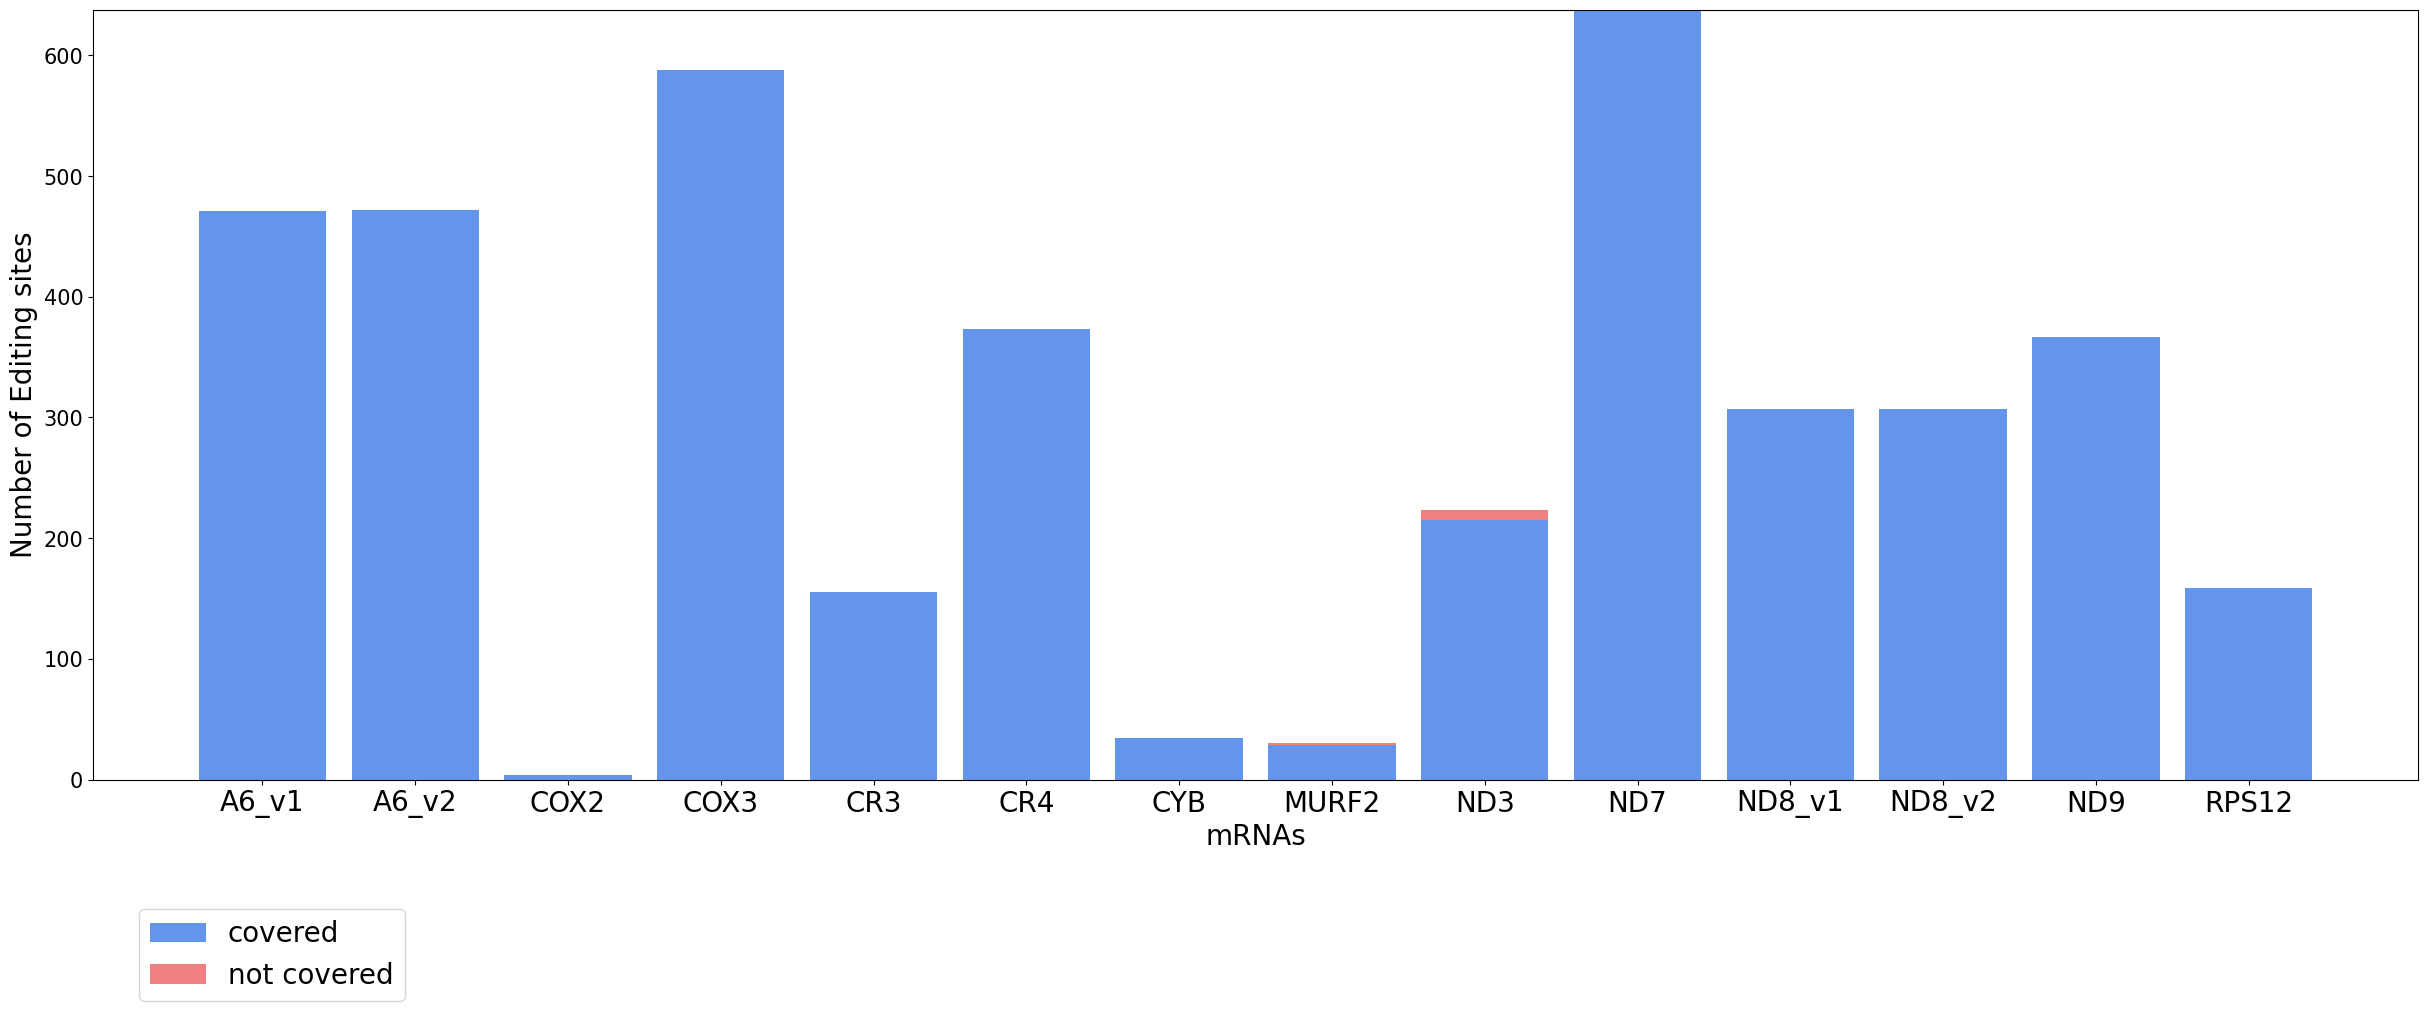

In [30]:
def make_subspecies_gRNA_coverage(taxon):
    minilist=extract_other(combined,taxon)
    grnas=extract_gRNA_present(gRNA_dict,minilist)
    print(len(grnas))
    mrnas=make_mRNA_files(insertions,deletions)
    mrnas=make_gRNA_coverage(grnas,mrnas,anchor=6)
    df=gRNA_coverage(mrnas,taxon, outdir,width=0.35, figw=30,figh=10)
    #print(df)
    return(mrnas)
#excutions
mrnas=make_subspecies_gRNA_coverage('T.b. gambiense type II')  


23 1992
4783/13401 gRNAs were present in 1992 minicircles
4783
MURF2


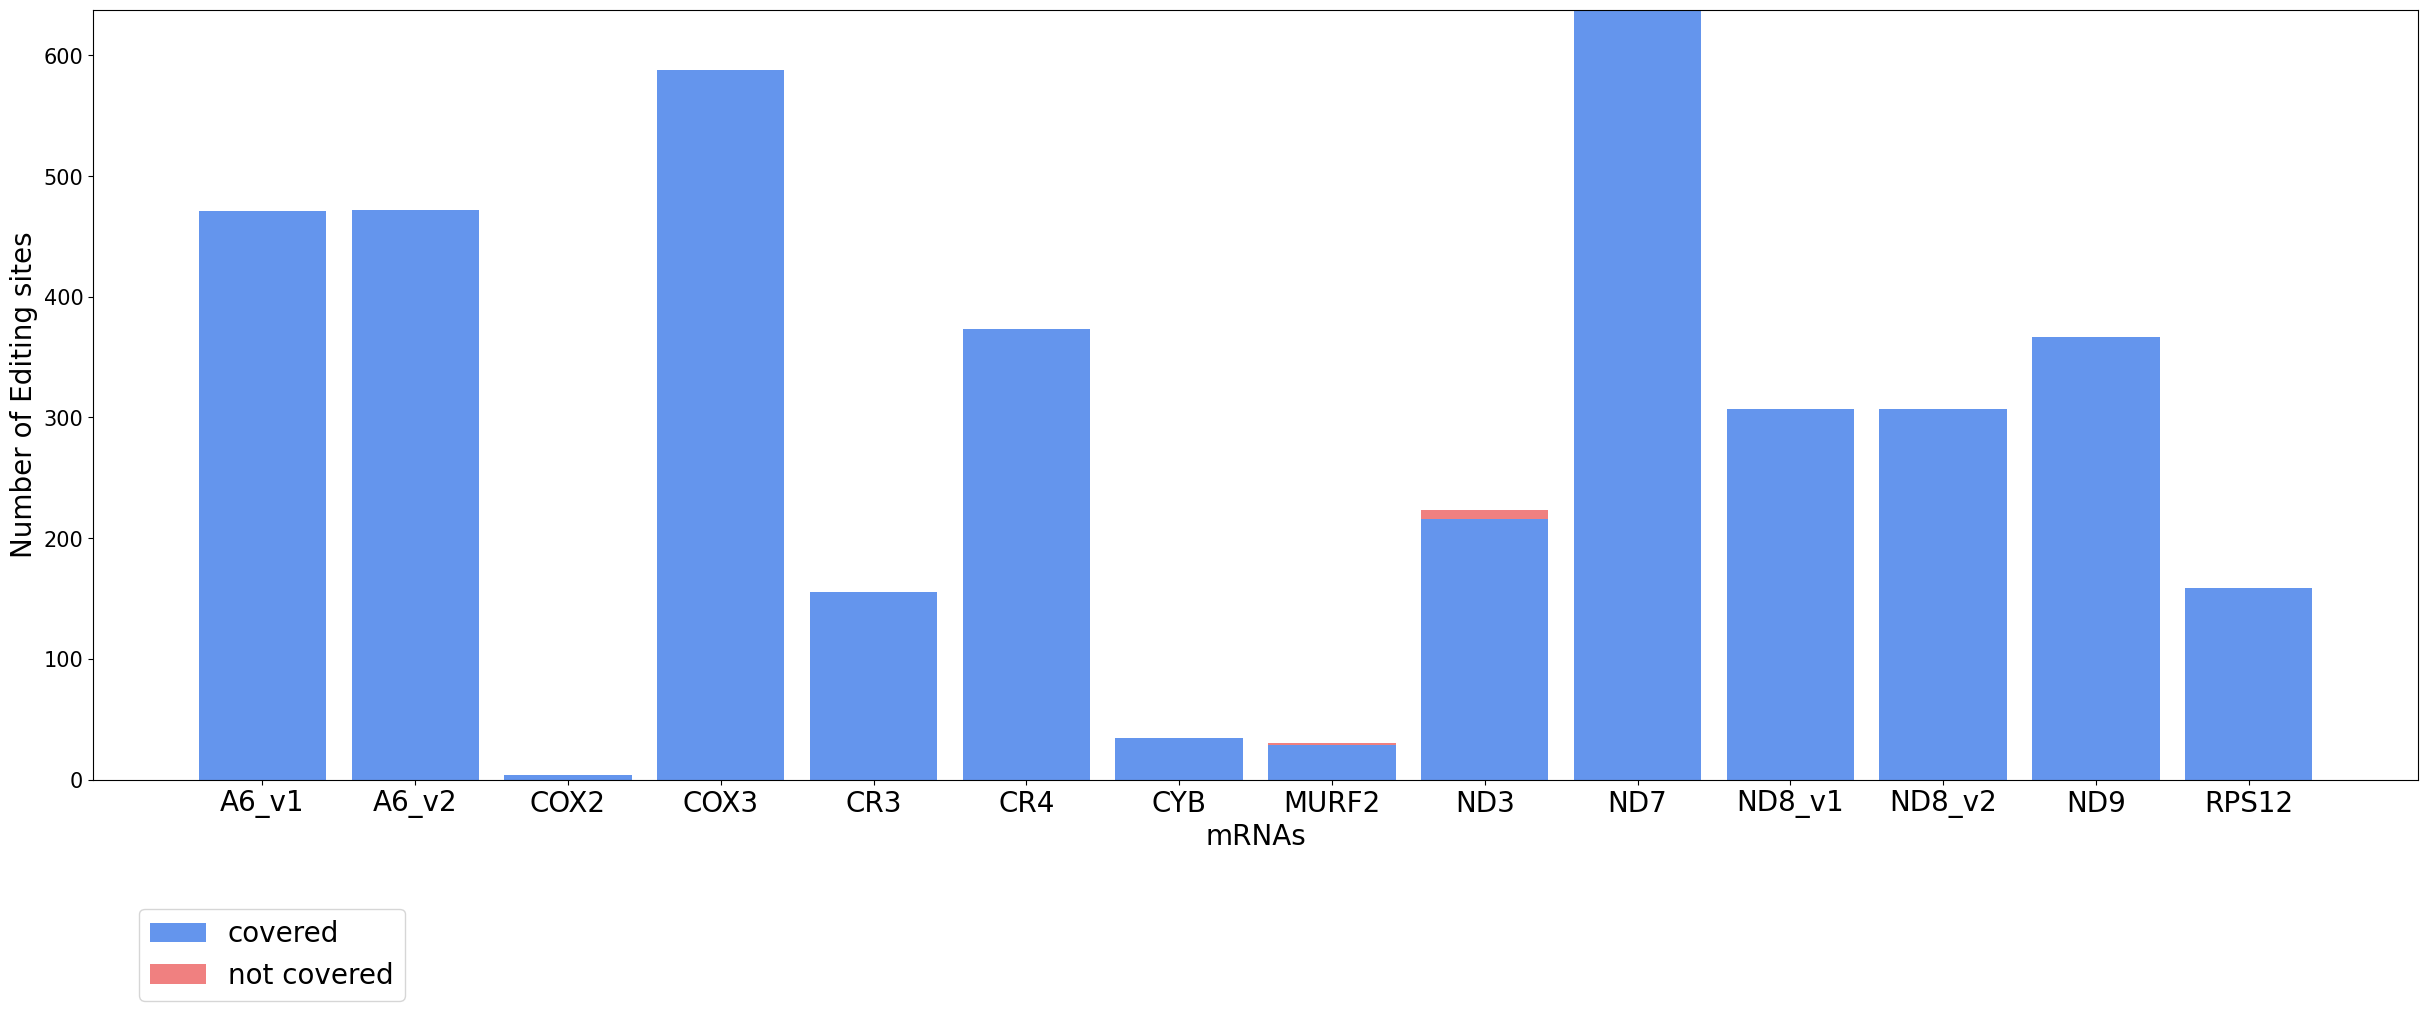

In [31]:
mrnas=make_subspecies_gRNA_coverage('T.b. rhodesiense')   

76 4890
11583/13401 gRNAs were present in 4890 minicircles
11583
MURF2


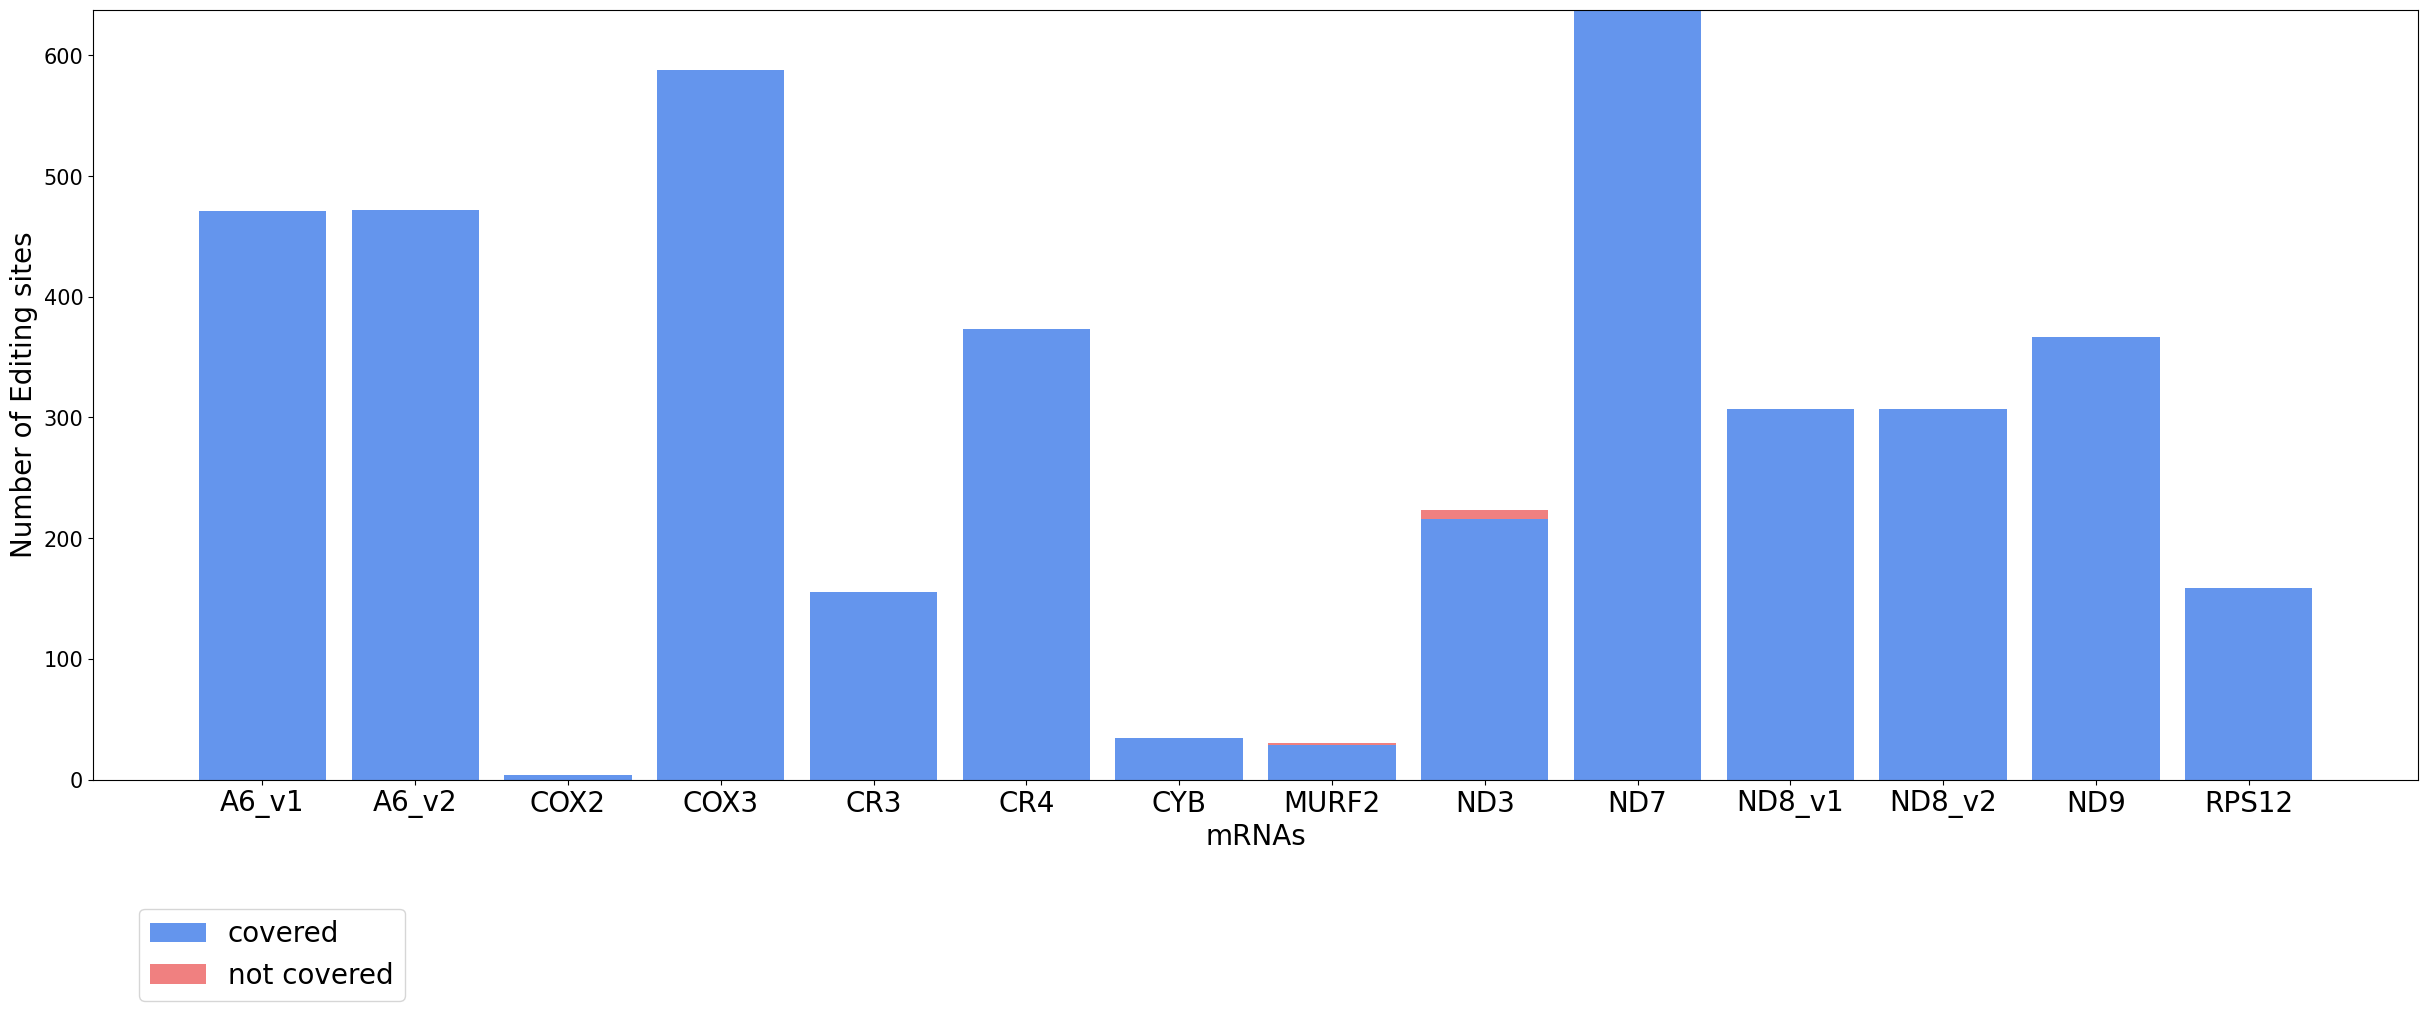

In [33]:
mrnas=make_subspecies_gRNA_coverage('T.b. brucei')   

In [32]:
tbgI_mini=combined[combined['taxon']=='T.b. gambiense type I'].dropna(axis='columns',how='all')
def with_alternative(tbgI_mini,m1,m2):
    all=set(tbgI_mini.index)
    set1=set(tbgI_mini[~tbgI_mini[m1].isna()].index)
    set2=set(tbgI_mini[~tbgI_mini[m2].isna()].index)
    print(len(tbgI_mini),len(set1), len(set2),len(set1.intersection(set2)),len(all-set1-set2))
    print(tbgI_mini.loc[list(all-set1-set2)]['minicircle_classes'])

#COX3_v1, COX3_v2
with_alternative(tbgI_mini,'Tb_mO_1680','Tb_mO_1984')
#ND8 v1, v2
with_alternative(tbgI_mini,'Tb_mO_647','Tb_mO_856')

111 64 80 39 6
renamed
TbgI_BRAZAVILLE-BB                   114
TbgI_MSUS-CI-82-TSW125-KP1-cloneB    112
TbgI_AnTat-21-1                      110
TbgI_KIN-1                            77
TbgI_BAT31                           105
TbgI_Bosendja                         80
Name: minicircle_classes, dtype: int64
111 101 72 68 6
renamed
TbgI_A005                  110
TbgI_MHOM-CI-78-DALOA69    124
TbgI_LiTat-1-3              54
TbgI_BIP28                 103
TbgI_LiTat-1-5-P9           56
TbgI_349BT                 106
Name: minicircle_classes, dtype: int64


In [23]:
#draw average gRNA coverage over TbgI with error bar

Interestingly, the minicircle and nuclear genome phylogenies exhibited a transition zone between the major Western and Eastern African clades. Eastern African isolates found in the transition zone were predominately from Uganda and Ethiopia, coinciding the countries along the geographical barrier between the parasite population. Cases of T. b. rhodesiense and T. b. gambiense type I has long been reported in Uganda, which had been regarded as the main focus that allowed genetic exchange of parasites cross the continent [36]. Although no case was reported form Ethiopia hitherto, its location on the boundary of acute and chronical HAT epidemic humoured the probability of coinfection. The transition zone suggested that the porous boundary between Western an Eastern T. brucei population allowed transmission cross geographical barriers at multiple foci and provided the opportunity for the spread of SRA genes into Western Africa through hybridization [3, 8, 37]. 

Although the maxicircle phylogeny did not exhibit the same structure, we noticed within the Western African clade a subclade containing T. b. rhodesiense from Uganda, Kenya, Ethiopia, and Sudan, which indicated series of probable hybridization with Western African T. b. brucei and the subsequent spread of maxicircle with Western African origin towards the East into Kenya [36, 38]. Given the uniparental inheritance of maxicircle, some cells probably lost the maxicircles with Eastern African origins shortly after gamete fusion, establishing and expanding after emerging from a bottleneck. The detection of T. b. rhodesiense in Sudan, a country west of the putative boundary of its distribution, also pointed to the spread or potentially wider epidemiology of acute HAT. 


In [24]:
#Tbr isolates from Sudan
combined[combined['country']=='Sudan'][['strain', 'alias 1', 'alias 2', 'seq batch', 'seq platform ','read length ', 'taxon', 'Year of isolation', 'country', 'continent','location', 'host', 'TgsGP-qPCR', 'SRA-qPCR', 'minicircle_classes']]

,strain,alias 1,alias 2,seq batch,seq platform,read length,taxon,Year of isolation,country,continent,location,host,TgsGP-qPCR,SRA-qPCR,minicircle_classes
renamed,,,,,,,,,,,,,,,
TbgI_MHOM-SD-82-SUZENA,NaN,NaN,NaN,BATCH3,BGI,150,T.b. gambiense type I,1982,Sudan,North Africa,Yambio,man,NaN,NaN,120
Tbr_MHOM-SD-82-BIYAMINA-bis,MHOM/SD/82/BIYAMINA,BIYAMINA,K 2567,BATCH3,BGI,150,T.b. rhodesiense,1982,Sudan,North Africa,YAMBIO,man,NaN,NaN,376
Tbr_MHOM-SD-82-BIYAMINA,MHOM/SD/82/BIYAMINA,BIYAMINA,K 2567,BATCH1,BGI,150,T.b. rhodesiense,1982,Sudan,North Africa,YAMBIO,man,NaN,NaN,381


In [25]:
#combine different versions (simply remove _v*) from gRNA dict
def drop_versions(gRNA_dict):
    for k,v in gRNA_dict.items():
        if '_v' in v['mRNA_name']:
            v['name']=v['name'].replace(v['mRNA_name'],v['product'])
            v['mRNA_name']=v['product']
    return gRNA_dict

In [26]:
#strains with alternative editing
#rename minicircles with clean.log file
clean_mini_log='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_cleaned_minicircles.log'
tbg1grna=rename_minicircles(tbg1grna,clean_mini_log) 


{'gRNA_0': {'mO_name': 'Maxicircle',
  'cassette_label': 'Maxi',
  'strand': 'coding',
  'length': '47',
  'rel_start': '0',
  'circle_start': '0',
  'circle_end': '47',
  'mRNA_name': 'MURF2',
  'product': 'MURF2',
  'mRNA_start': '29',
  'mRNA_end': '76',
  'mRNA_seq': 'UGAuuuuAAuGuuuGGuuGuuuuAAuuuAGuuuuAUUuuuGuGCUUU',
  'gRNA_seq': 'AUUAAAAUUGUAGGUUAAUGAGAUUAAAUUAAAAUAAAAACACGAAA',
  'pairing': '|:|||||||::|::::||::|:|||||||:|||||||||||||||||',
  'mismatches': '0',
  'anchor_len': '17',
  'name': 'Maxicircle_gMURF2(30-76)',
  'anchor_type': 'unanchored',
  'rel_pos': '0',
  'family_no': '0',
  'family_end': '76',
  'family_id': 'MURF2-Maxi-76'},
 'gRNA_1': {'mO_name': 'Tb_mO_5535',
  'cassette_label': 'II',
  'strand': 'coding',
  'length': '39',
  'rel_start': '35',
  'circle_start': '368',
  'circle_end': '407',
  'mRNA_name': 'ND8_v1',
  'product': 'ND8',
  'mRNA_start': '187',
  'mRNA_end': '226',
  'mRNA_seq': 'uuuuuGCGUUUUuAUUGGuGuGGuuuAGAGCGuuGuAuu',
  'gRNA_seq': 'AAAAGUGUAA